# Forward Feature Selection to Find an Optimum Feature List

In this project, we will create a Forward Elimination method to find optimum feature set.

We have a data with 30+ features that includes sales, campaign and production informations.

# Steps to find an optimum features set

1.Train model with all features individually and check the performance.
2.Select the first feature that gives the minimum Mean Absolute Percentage Error.
3.Repeat the process and add one feature at a time
4.After tried all features, find the optimum features set.





# Loading the data

First we should import the usefull packages. We will use XGBoost library for performing features.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

Mape calculation finds to percentage of the error.

**MAPE = (|Y_true - Y_pred|/Y_true)*100

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

We are ready to read data with pandas. If there are duplicated rows we should eliminate them using primary key features.

In [15]:
df = pd.read_csv('DATA.csv')
df.drop_duplicates(subset = ['Yıl','Ay','Bölüm5 Kod', 'MusteriGrup'],inplace=True)

Create a list for all features and remove the outcome and string values.

In [16]:
df_columns = df.columns.tolist()
df_columns.remove('Bölüm5 Kod')
df_columns.remove('ToplamTonaj')
df_columns.remove('MusteriGrup')

In [17]:
firstColumn = ''


EliminationScores = pd.DataFrame(columns = ['Feature','mape'])
bestScores = pd.DataFrame(columns = ['Method','Features','mape'])


We will create a new feature that includes year and month info and use it for separate the train and test data.

In [18]:
df['YılAy'] = df['Yıl']*12 + df['Ay']

Now we can create a loop for find the first feature. 

Train and test data will be rolling. Each cyle we will estimate 1 month, after prediction we will add feature and mape to a dataframe.

Tested several algorithm for the best result. We will use XGBoost for predictions. Optimal parameters are 40 for estimator count, 6 for max depth.

**After all 3 months are predicted, we will calculate a Weighted Avreages of MAPE.

In [19]:
start = 3
end = 6
if(firstColumn == ''):
    for col in df_columns:
        scores=pd.DataFrame(columns=['Yıl','Ay','Bölüm5 Kod','predictionMethod',
                                  'real','prediction','error','mape'])
        
        for ay in range(start,end):    
            
              
            X_train, X_test = pd.DataFrame(df[(df['YılAy'] <2020*12+ay)][col]), pd.DataFrame(df[(df['YılAy'] ==2020*12+ay)][col])
            y_train, y_true =df[(df['YılAy'] <2020*12+ay)]['ToplamTonaj'], df[(df['YılAy'] ==2020*12+ay)]['ToplamTonaj']
            
        
            estimator = XGBRegressor(n_estimators = 40, max_depth=6, objective = 'reg:squarederror')
        
            estimator.fit(X_train,y_train.values.ravel())
            y_pred= estimator.predict(X_test)
            
                    
            mapeTree = mean_absolute_percentage_error(y_true,y_pred)
            
            scores=scores.append({'Yıl':2020,'Ay':ay,'Bölüm5 Kod':df['Bölüm5 Kod'].iloc[0],'predictionMethod':'XGB',
                                  'real':y_true.iloc[0],'prediction':y_pred[0],'error':y_pred[0]-y_true.iloc[0], 'mape':mapeTree}, ignore_index=True)
        
            
            
        WeightedMape = (scores.mape * scores.real).sum()
        scoresMean = WeightedMape / scores.real.sum()
                    
        EliminationScores = EliminationScores.append({'Feature':col,'mape':scoresMean},ignore_index = True)
    firstColumn = EliminationScores[EliminationScores['mape'] == EliminationScores['mape'].min()]['Feature'].iloc[0]
   

This is the first feature with the minimum MAPE.

In [20]:
print ('{}-{}'.format(df['Bölüm5 Kod'].iloc[0],firstColumn))

5-Boya ÜFE_RM12


And this is the feature scores.

In [21]:
print(EliminationScores.sort_values(by='mape'))

                                             Feature         mape
26                Binalar Ve Bina İnşaat İşleri_RM12    27.997728
25                                     Boya ÜFE_RM12    27.997728
27                 Binalar Ve Bina İnşaat İşleri_RM6    33.775868
24                                      Boya ÜFE_RM6    34.056435
31                                               Yıl    48.089613
14  Tüketici Fiyatlarının Değişimine Ilişkin Düşünce    49.191253
28                                      ToptanciStok    65.055608
17                                     Pesin_GecenAy    67.743182
5                        Boya Tüketici Fiyat Endeksi    99.936220
16                                          USD_Std6   637.506246
4                                    BolgeDepoSayısı   709.805157
22     Yapı Kullanma İzin Belgesi - Daire Sayısı_RM6   812.223806
19                                       ToplamHedef   902.693514
10                               VadeIskonto_GecenAy   934.299149
1         

Now we found the first feature. We will add other features one by one.

modelColumns dataframe will be our feature set. We will add the selected features in to this data frame and remove them from df_columns list.

In [22]:
modelColumns = [firstColumn]
    
df_columns.remove(firstColumn)

ModelResultsForward = pd.DataFrame(columns=['Features','num_feature','mape'])
    

In the one cyle of the while loop, the model will try to add all features one by one to features set.

And add the best feature to the modelColumns dataframe. 

When one cyle is completed, the best feature is removed from the loop, and continue with the features left behind.


In [24]:
while len(df_columns)>0:
        
    EliminationScores = pd.DataFrame(columns = ['Feature','mape','modelColumns'])

    for col in df_columns:

        if(col != 'Bölüm5 Kod' and col != 'ToplamTonaj' and col not in modelColumns):

            scores=pd.DataFrame(columns=['Yıl','Ay','Bölüm5 Kod','predictionMethod',
                                      'real','prediction','error','mape'])

            modelColumns.append(col)

            for ay in range(start,end):    


                X_train, X_test = pd.DataFrame(df[(df['YılAy'] <2020*12+ay)][modelColumns]), pd.DataFrame(df[(df['YılAy'] ==2020*12+ay)][modelColumns])
                y_train, y_true =df[(df['YılAy'] <2020*12+ay)]['ToplamTonaj'], df[(df['YılAy'] ==2020*12+ay)]['ToplamTonaj']


                estimator = XGBRegressor(n_estimators = 40, max_depth=6, objective = 'reg:squarederror')

                estimator.fit(X_train,y_train.values.ravel())
                y_pred= estimator.predict(X_test)
                # y_pred


                mapeTree = mean_absolute_percentage_error(y_true,y_pred)

                scores=scores.append({'Yıl':2020,'Ay':ay,'Bölüm5 Kod':df['Bölüm5 Kod'].iloc[0],'predictionMethod':'XGB',
                                          'real':y_true.iloc[0],'prediction':y_pred[0],'error':y_pred[0]-y_true.iloc[0], 'mape':mapeTree}, ignore_index=True)
                
            WeightedMape = (scores.mape * scores.real).sum()
            scoresMean = WeightedMape / scores.real.sum()  

            EliminationScores = EliminationScores.append({'Feature':col,'mape':scoresMean,'modelColumns':modelColumns.copy()},ignore_index = True)

            modelColumns.pop()

    best = EliminationScores[EliminationScores['mape'] == EliminationScores['mape'].min()]['Feature'].iloc[0]


    modelColumns = EliminationScores[EliminationScores['mape'] == EliminationScores['mape'].min()]['modelColumns'].iloc[0]



    ts = modelColumns.copy()
    ModelResultsForward = ModelResultsForward.append({'Features':ts,'num_feature':len(ts),'mape':EliminationScores['mape'].min()},ignore_index=True)
    del ts


    df_columns.remove(best)
    print(len(df_columns))
    print(modelColumns)
    print('MAPE: ' + str(EliminationScores['mape'].min()))
    print('--------------------------')

In [36]:
print(ModelResultsForward.sort_values(by='mape'))

                                             Features num_feature       mape
16  [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          18   8.181590
17  [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          19  11.010276
20  [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          22  12.203155
18  [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          20  12.203155
19  [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          21  12.203155
25  [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          27  26.410969
12  [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          14  26.938653
11  [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          13  26.938653
9   [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...          11  26.938653
0   [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...           2  26.938653
7   [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...           9  26.938653
6   [Boya ÜFE_RM12, Binalar Ve Bina İnşaat İşleri_...           8  26.938653

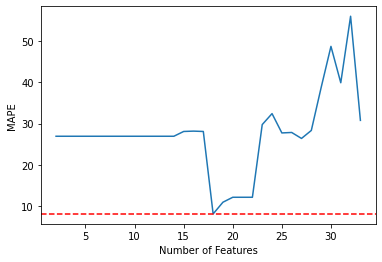

In [35]:
plt.plot(ModelResultsForward['num_feature'],ModelResultsForward['mape'])
plt.ylabel('MAPE')
plt.xlabel('Number of Features')
plt.axhline(y=ModelResultsForward['mape'].min(), color='r', linestyle='--')

plt.show()

### Final Conclusion

When the model has too many feature, it could cause overfitting and more processing times. So we should find the optimum number of features when we use the model. 

As you can see at the example, there are 30+ features but only 18 of them give us the best accuracy. 

Forward elimination could be usefull when the data has correlated features. But it could take much time if the data has big amount of features. In this stuation we can use special feature selection libraries like Lasso, Ridge, Recursive etc.